### SVM

I'm using a different dataset (compared to logistic regression and random forest) for SVM. It is an image dataset which can be loaded from sklearn.

There are some disadvantages of using SVM:

* It is relatively slow. Time complexity is O (N^3) at worst, or O (N^2) for efficient implementations. For large numbers of training samples, the algorithm is slow and computational cost is high.

* The performance of SVM highly depends on suitable choices for the softening parameter C and kernel. The choice of kernel depends on your understanding of the data. It is one of the reasons I do not use SVM often - I haven't encounter a scenario where projecting the data into a higher dimension space would separate different classes better. 

* Parameter tuning can be done via cross-validation, which makes the training process more expensive as the dataset grow in size.

* The results do not have a direct probabilistic interpretation.

Advantages of SVM:

* They are affected only by points near the margin

* They work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.

* Kernels make SVM very versatile and be able to adapt to many types of data.

In [ ]:
from sklearn.datasets import fetch_lfw_people
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [ ]:
face_df = fetch_lfw_people(min_faces_per_person=60)
print(face_df.target_names)
print(face_df.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Our dataset consists of 62*47 images and has people's names as labels. Our objective is to correctly predict who the person is given an image.

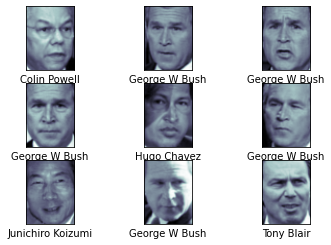

In [ ]:
fig, ax = plt.subplots(3, 3)
for i, axi in enumerate(ax.flat):
    axi.imshow(face_df.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=face_df.target_names[face_df.target[i]])

#### Use PCA to get features from data

In [ ]:
n_comp = 150
pca = RandomizedPCA(n_components=n_comp, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
# integrate the process of gettng pcs from svm and running svm
model = make_pipeline(pca, svc)

#### parameter tuning

As we have mentioned, choosing suitable parameters is very importannt for SVM's performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(face_df.data, face_df.target, test_size=0.3, random_state=42)

param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)
model = grid.best_estimator_
print(grid.best_params_)

CPU times: user 40.8 s, sys: 27.5 s, total: 1min 8s
Wall time: 37 s
{'svc__C': 5, 'svc__gamma': 0.001}


#### Model Performance

In [ ]:
# we define a new function to give us evaluation metrics and visualizations (with codes in Logistic_Regression.ipynb)
def plot_confusion(model, X_test, y_test):
  # predicted values on the testing data
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))

  # print accuracy
  print('Accuracy: ', sum(y_pred == y_test)/len(y_test))

  # The confusion matrix
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  # Convert confusion matrix into dataframe
  matrix_df = pd.DataFrame(confusion_matrix)


  plt.figure(figsize=(8, 8))
  ax = plt.axes()
  sns.set(font_scale=1.3)

  sns.heatmap(matrix_df,
              annot = True, 
              fmt = "g",
              ax = ax, 
              cmap = "magma", 
              cbar = False)

  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Label", fontsize=15)
  ax.set_xticklabels(face_df.target_names, rotation = 45)
  ax.set_ylabel("True Label", fontsize=15)
  ax.set_yticklabels(face_df.target_names, rotation=0)
  plt.show()

              precision    recall  f1-score   support

           0       0.68      0.88      0.77        17
           1       0.80      0.86      0.83        84
           2       0.67      0.89      0.76        36
           3       0.91      0.77      0.83       146
           4       0.70      0.75      0.72        28
           5       0.89      0.63      0.74        27
           6       0.79      0.94      0.86        16
           7       0.72      0.76      0.74        51

    accuracy                           0.80       405
   macro avg       0.77      0.81      0.78       405
weighted avg       0.81      0.80      0.80       405

Accuracy:  0.7975308641975308


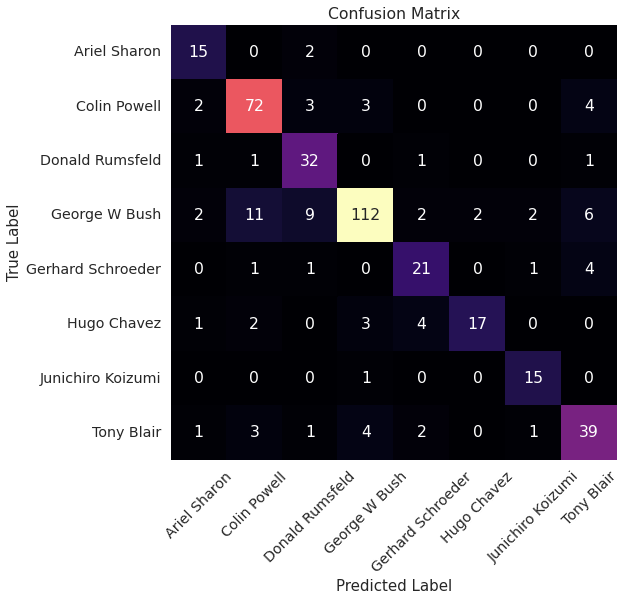

In [ ]:
plot_confusion(model, X_test, y_test)

From the results we can see that the model achieves an accuracy rate of 80%, getting the majority of the person's names right. It seems like our svm classifier often makes the mistake of classfying Bush's images as Powell or Rumsfeld.

#### Visualize the misclassified cases

A special error analysis that we can do for image classification dataset is to visualize a misclassified sample and see if it is a reasonable mistake.

In [ ]:
# get misclassified samples
def get_mis_idx(lst, element):
    index_pos_list = []
    for i in range(len(lst)):
        if lst[i] == element:
            index_pos_list.append(i)
    return index_pos_list

y_pred = model.predict(X_test)
wrong_class_lst = get_mis_idx(list(y_pred != y_test), True)

true_labels = y_test[wrong_class_lst]
pred_labels = y_pred[wrong_class_lst]

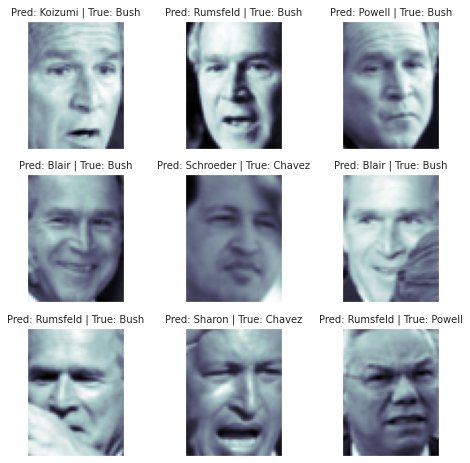

In [ ]:
X_wrong = X_test[wrong_class_lst]
fig, ax = plt.subplots(3,3, figsize = (8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_wrong[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_title(('Pred: ' + (str(face_df.target_names[pred_labels[i]]).split()[-1]) + ' | True: ' + (str(face_df.target_names[true_labels[i]])).split()[-1]),fontsize=10)

#### Changing number of features from pca


In [ ]:
for n_comp in [80,100,120,170]:
  pca = RandomizedPCA(n_components=n_comp, whiten=True, svd_solver='randomized', random_state=42)
  svc = SVC(kernel='rbf', class_weight='balanced', C = 5, gamma = 0.001)
  # integrate the process of gettng pcs from svm and running svm
  model = make_pipeline(pca, svc)
  print('********************************************')
  print('Number of PCs: ', n_comp)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))

  # print accuracy
  print('Accuracy: ', sum(y_pred == y_test)/len(y_test))

********************************************
Number of PCs:  80
              precision    recall  f1-score   support

           0       0.52      0.76      0.62        17
           1       0.90      0.82      0.86        84
           2       0.58      0.86      0.70        36
           3       0.93      0.77      0.84       146
           4       0.53      0.71      0.61        28
           5       0.81      0.63      0.71        27
           6       0.84      1.00      0.91        16
           7       0.75      0.76      0.76        51

    accuracy                           0.78       405
   macro avg       0.73      0.79      0.75       405
weighted avg       0.81      0.78      0.79       405

Accuracy:  0.782716049382716
********************************************
Number of PCs:  100
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        17
           1       0.90      0.86      0.88        84
           2       0.57     

Changing the number of pc as features does not significantly improve the results. With 100/ 120 PCs we get a slightly higher accuracy of 81% instead of 80%.